# Setup

In [1]:
# Retrieve the OpenAI API key from Collab's user data
from google.colab import userdata
open_ai_key = userdata.get('openai_api')

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change directory to project folder
%cd /content/drive/MyDrive/AI\ Projects/RAG\ Course/8_Multi_Modal_RAG

/content/drive/MyDrive/AI Projects/RAG Course/8_Multi_Modal_RAG


## Step 1: Get The Data - Video file

In [4]:
# Define the Video Path
video_path = "dinakajoy-introduction.mp4"

## Step 2: Extract The Audio and Compress

In [5]:
# Install libraries for audio processing and  handling multimedia files
!pip install -q pydub
!apt-get install -q ffmpeg

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [6]:
# Import Libraries
import os
import subprocess
from pydub import AudioSegment

In [7]:
# Define the audio path
audio_output_path = "audios/output.mp3"

In [8]:
# Ensure the output directory exists
output_dir = os.path.dirname(audio_output_path)

# Create the directory if it does not already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [9]:
# Ensure the output file has the correct extension
if not audio_output_path.endswith(".mp3"):
    audio_output_path += ".mp3"

In [10]:
# Construct the ffmpeg command to extract the audio
command = [
    'ffmpeg',
    '-y',                     # overwrites if the audio exists
    '-i', video_path,         # input file
    '-vn',                    # No video
    '-acodec', 'libmp3lame',  # Audio codecs
    audio_output_path         # output file
]

In [11]:
# Execute the command to extract the audio
subprocess.run(command, check = True)

CompletedProcess(args=['ffmpeg', '-y', '-i', 'dinakajoy-introduction.mp4', '-vn', '-acodec', 'libmp3lame', 'audios/output.mp3'], returncode=0)

In [12]:
# Set the bitrate
bitrate = "32k"

In [13]:
# Set the path for compressed audio
compressed_audio_path = "audios/compressed.mp3"

In [14]:
# Construct the ffmpeg command to compress the audio
command = [
    'ffmpeg',
    '-y',                    # Overwrite output file if it exists
    '-i', audio_output_path, # Input audio file path
    '-ab', bitrate,          # Audio bitrate for compression
    compressed_audio_path    # Output compressed audio file path
]

# Execute the ffmpeg command to compress the audio
subprocess.run(command, check=True)

CompletedProcess(args=['ffmpeg', '-y', '-i', 'audios/output.mp3', '-ab', '32k', 'audios/compressed.mp3'], returncode=0)

## Step 3: Transcribe Audio using OpenAI API

In [15]:
# Install the openAI library
! pip install -q openai

In [16]:
# Import OpenAI library
from openai import OpenAI

In [17]:
# Connect to the OpenAI API
client = OpenAI(api_key = open_ai_key)

In [18]:
# Open the compressed audio file in binary mode
with open(compressed_audio_path, "rb") as audio_file:
  # Use the whisper model to transcribe the audio
  transcript = client.audio.transcriptions.create(
      model = "whisper-1",
      file = audio_file
  )

In [19]:
# Inspect the transcript
transcript.text

"My name is Ozinaka Joy. I'm a back-end AV developer with over four years of experience building web applications for startups and open source organizations. I specialize in TypeScript and Node.js, working with tools like Next.js and Express.js to build reliable and scalable systems that are user-focused based on empathy. Over the years, I've also contributed to open source projects, methoded other developers, and spoken at some tech events. Beyond JavaScript, I have worked with OCaml through open source contributions and internships, and I'm building my knowledge of Python as I dive deeper into artificial intelligence. So far, so good. I've been focused on natural language processing and large language models, and I've got to work with tools like LangChain, Clue.ai, and HoganFace. Some of my recent projects bring web and AI together, such as Job Application Assistance, which is an app that helps users to match job descriptions to their resume, and also generate cover letters. The seco

In [20]:
# Define the path where the transcription will be saved
transcript_path = "transcripts/transcript.txt"

In [21]:
# Ensure the output directory exists
output_dir = os.path.dirname(transcript_path)
# Create the directory if it does not already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [22]:
# Save the transcribed text to a file
with open(transcript_path, "w") as f:
  f.write(transcript.text)

## Step 4: Extract Frames From The Video

In [23]:
# Install the moviepy library to handle video data
!pip install -q moviepy

In [24]:
# Load moviepy library
from moviepy.editor import VideoFileClip

In [25]:
# Define the output folder for storing frames
output_folder = "frames"
# Create the folder if it does not exist already
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [26]:
# Load the video
video = VideoFileClip(video_path)

In [27]:
# Extract frames from the video at regular intervals
frame_interval = 10 # Time interval between frames in seconds
frame_paths = []

for t in range(0, int(video.duration), frame_interval):
    # Construct the file path for each frame
    frame_path = os.path.join(output_folder, f"frame_{t:04d}.png")

    # Extract the frame at the current time
    video.save_frame(frame_path, t=t)

    # Append the path of the saved frame to the list
    frame_paths.append(frame_path)

## Step 5: Embed The Audio

In [28]:
# Import libraries
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch
import numpy as np

In [29]:
# Load libraries
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
# Read the transcribed text from the file
with open(transcript_path, "r") as f:
    transcript_text = f.read()

In [31]:
# Tokenize the entire transcript text
tokens = tokenizer(transcript_text,
                   return_tensors = "pt", # Return tensors for PyTorch
                   padding=True) # Pad sequences to the same length

# Extract the input_ids from the tokenized output
input_ids = tokens["input_ids"][0]

# Print the number of tokens
print(f"Number of tokens: {len(input_ids)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (392 > 77). Running this sequence through the model will result in indexing errors


Number of tokens: 392


In [32]:
# The CLIP model requires 77 tokens per chunk
max_tokens = 77
transcription_chunks = []

# Split the tokens into chunks of up to max_tokens tokens each
for i in range(0, len(input_ids), max_tokens):
    chunk = input_ids[i:i+max_tokens]
    transcription_chunks.append(chunk)

# Print the number of chunks created
print(f"Number of chunks: {len(transcription_chunks)}")

Number of chunks: 6


In [33]:
# Inspect the transcription_chunks
transcription_chunks

[tensor([49406,   607,  1981,   533, 10584,   512,  3412,  4273,   269,   328,
           880,   320,   893,   268,   806,  8484, 10929,   593,   962,  2721,
          1151,   539,  2415,  2307,  4601,  7341,   556,  9056,   537,  1488,
          3634, 13453,   269,   328,  1969, 10268,   530, 15673,  8374,   537,
         24871,   269,  8006,   267,  1699,   593,  5771,   789,  1131,   269,
          8006,   537,  5642,   269,  8006,   531,  3289, 13714,   537, 44084,
          4828,   682,   631,  7031,   268,  9319,  2812,   525, 22420,   269,
           962,   518,  1151,   267,   328,  1200,  1446]),
 tensor([19397,   531,  1488,  3634,  5090,   267,  5770,  1241,  1010, 13248,
           267,   537, 12979,   536,   836,  2061,  3667,   269,  4432, 16423,
           267,   328,   720,  5410,   593,    78,  1004,   331,  1417,  1488,
          3634, 14465,   537, 39410,   267,   537,   328,   880,  2307,   607,
          5510,   539, 13370,   601,   328,  9058, 15224,  1095, 12040,

In [34]:
# Text Embeddings -> embed the tokens in each chunk
text_embeddings = []

# Iterate through each chunk
for chunk in transcription_chunks:
  # Ensure the chunk is in the correct shape for the model
  inputs = {"input_ids": chunk.unsqueeze(0)}

  # Get the text embedding for the chunk
  with torch.no_grad():
    text_embedding = model.get_text_features(**inputs)
    # Convert the embeddings to a numpy array
    text_embeddings.append(text_embedding.cpu().numpy().flatten())

# Convert the list of embeddings to a numpy array
text_embedding_np = np.array(text_embeddings)

# Print the shape of the text embeddings array
print(f"Text embedding shape is: {text_embedding_np.shape}")

Text embedding shape is: (6, 512)


In [35]:
# Inspect the text embeddings numpy array
text_embedding_np

array([[ 0.02291096,  0.06127312, -0.10674023, ...,  0.18032408,
         0.03520007,  0.00395092],
       [ 0.3730327 , -0.2417814 ,  0.2889818 , ..., -0.05721687,
        -0.18801081,  0.16412002],
       [-0.03424497, -0.10422853,  0.18326195, ..., -0.27410614,
        -0.18915936, -0.01773587],
       [ 0.27185893,  0.11449615, -0.44592214, ..., -0.06183781,
        -0.51771665,  0.14923732],
       [ 0.08687586, -0.4352323 ,  0.01061933, ..., -0.0155713 ,
        -0.16199243, -0.11329472],
       [-0.01335338, -0.03524818,  0.2528231 , ..., -0.18490885,
        -0.08753297,  0.27797723]], dtype=float32)

## Step 6: Embedding The Images

In [36]:
# Import the PIL library
from PIL import Image

In [37]:
# Embed the images
frames_folder = "frames"
image_embeddings = []
image_paths = []

for frame_file in os.listdir(frames_folder):
  if frame_file.endswith(".png"):
    # Construct the path to the image file
    frame_path = os.path.join(frames_folder, frame_file)
    image_paths.append(frame_path)

    # Open and preprocess the image file
    image = Image.open(frame_path)
    inputs = processor(images = image, return_tensors = "pt")

    # Generate the image embedding
    with torch.no_grad():
      image_embedding = model.get_image_features(**inputs)
      # Convert the embedding to a numpy array and flatten it
      image_embeddings.append(image_embedding.cpu().numpy().flatten())

# Convert the list of embeddings to a numpy array
image_embedding_np = np.array(image_embeddings)

# Print the shape of the image embeddings array
print(f"Image embedding shape is: {image_embedding_np.shape}")

Image embedding shape is: (11, 512)


In [38]:
# Inspect the image embedding numpy array
image_embedding_np

array([[ 0.00065256,  0.07416229,  0.2517848 , ...,  0.41411093,
        -0.0385532 ,  0.06591802],
       [-0.04756361, -0.07420804,  0.3911054 , ...,  0.37610278,
         0.00451125,  0.21528895],
       [ 0.04504061,  0.01602411,  0.26749754, ...,  0.3239572 ,
        -0.03567705,  0.22802374],
       ...,
       [-0.01223746,  0.05746904,  0.29384392, ...,  0.41136062,
         0.00914198,  0.05291066],
       [ 0.06916384, -0.05217935,  0.34510648, ...,  0.4598913 ,
         0.03720264,  0.08615437],
       [-0.08841458, -0.14464071,  0.35744828, ...,  0.30547768,
         0.02570027,  0.12011619]], dtype=float32)

## Step: 7: Contrastive Learning

In [39]:
# Import Libraries
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [40]:
# Calculate the cosine similarity matrix between text and image embeddings
similarities = cosine_similarity(text_embedding_np,
                                 image_embedding_np)

# Print the cosine similarity matrix
similarities

array([[0.19887808, 0.20179276, 0.19322234, 0.2012747 , 0.19032308,
        0.19837637, 0.18699294, 0.18853363, 0.21496223, 0.19861597,
        0.19060546],
       [0.19988224, 0.21132892, 0.19941404, 0.18766189, 0.19164924,
        0.20467225, 0.18377712, 0.18791574, 0.20094949, 0.18954033,
        0.18181637],
       [0.20687489, 0.20262791, 0.19875695, 0.20685787, 0.20239124,
        0.21084824, 0.20224136, 0.20648074, 0.21059173, 0.1988966 ,
        0.19062062],
       [0.16932139, 0.16068158, 0.16622627, 0.1801926 , 0.173747  ,
        0.16676839, 0.16406152, 0.17493172, 0.19092636, 0.17368335,
        0.17480168],
       [0.16717719, 0.17549309, 0.1595956 , 0.16097355, 0.16187991,
        0.16796629, 0.16584022, 0.16204411, 0.17982031, 0.16707024,
        0.1487775 ],
       [0.21082546, 0.2105816 , 0.20450966, 0.21503223, 0.214064  ,
        0.21151364, 0.2086446 , 0.21147619, 0.21557231, 0.20956516,
        0.20876479]], dtype=float32)

In [41]:
# Check the shape of the similarities
print(f"The shape of the similarities is {similarities.shape}")

The shape of the similarities is (6, 11)


In [42]:
# Retrieve the top-k most similar images for each text chunk
top_k = 5
for i, text_chunk in enumerate(similarities):
  # Get indices of the top-k most similar images
  similar_indices = text_chunk.argsort()[-top_k:][::-1]
  print(f"Top {top_k} images for each chunk {i}: {similar_indices}")

Top 5 images for each chunk 0: [8 1 3 0 9]
Top 5 images for each chunk 1: [1 5 8 0 2]
Top 5 images for each chunk 2: [5 8 0 3 7]
Top 5 images for each chunk 3: [ 8  3  7 10  4]
Top 5 images for each chunk 4: [8 1 5 0 9]
Top 5 images for each chunk 5: [8 3 4 5 7]


In [43]:
# Set a random seed for reproducibility
random.seed(1502)

# Select 5 random text chunk indices
random_text_indices = random.sample(range(len(text_embedding_np)), 5)
print(f"Random text chunk indices: {random_text_indices}")

Random text chunk indices: [1, 4, 3, 5, 2]


In [44]:
# Find the 3 most similar images for each randomly selected text chunk
text_to_images_similarities = []
for idx in random_text_indices:
  # Get indices of the top 3 most similar images for the text chunk
  similar_images = similarities[idx].argsort()[-3:][::-1]
  text_to_images_similarities.append(similar_images)


  The text chunk 1: contributed to open source projects , metho ded other developers , and spoken at some tech events . beyond javascript , i have worked with o cam l through open source contributions and internships , and i 'm building my knowledge of python as i dive deeper into artificial intelligence . so far , so good . i 've been focused on natural language processing and large language models , and i 've got to work with


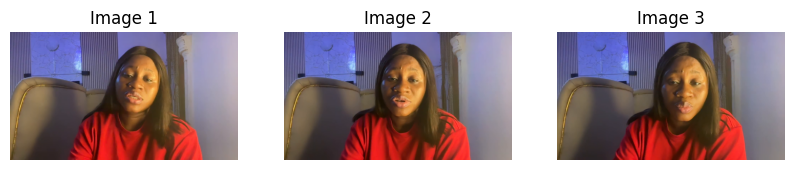


  The text chunk 2: - end engineering and ai . my goal is to combine strong back - end engineering with ai to build smarter and more impactful solutions across javascript , o cam l , and python ecosystems . so if you 're looking for a developer who brings both technical depth and a passion for innovation , i would love to connect . feel free to explore my projects below . i 'll do my best to reach out


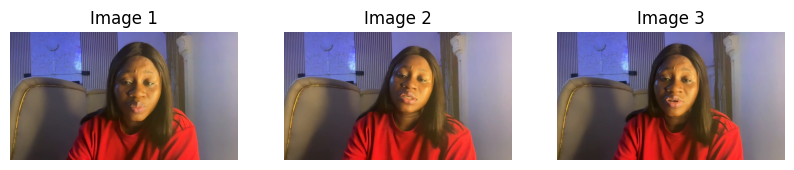


  The text chunk 3: a machine learning model that helps users predict if they need mental health treatment . number three is face detection app , where i consume qualifier 's api to detect faces on images . and recently , i built doc squ ery , which is a q addy system on private data using lang chain and ho gan face . each of these projects is focused on solving real - world problems through the combination of back


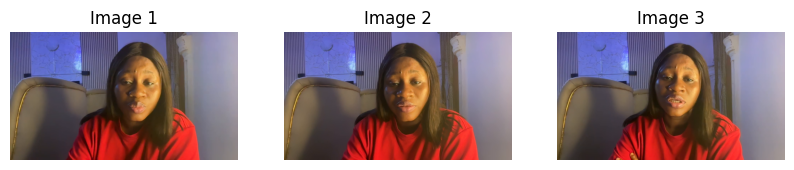


  The text chunk 4: . thank you for watching . <|endoftext|>


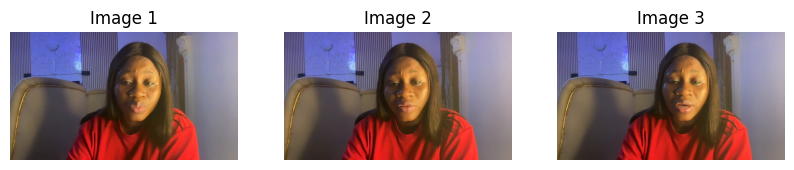


  The text chunk 5: tools like lang chain , clue . ai , and ho gan face . some of my recent projects bring web and ai together , such as job application assistance , which is an app that helps users to match job descriptions to their resume , and also generate cover letters . the second one is so sync , which is a mental health app that helps users to sync daily , and it also integr ates


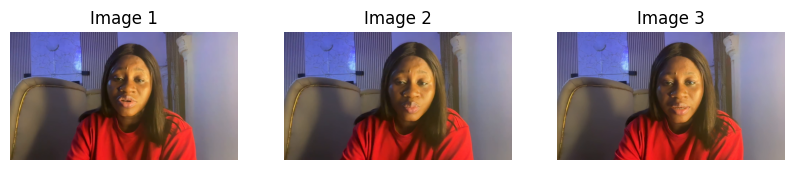

In [45]:
# Data visualization of the text and images
for i, text_index in enumerate(random_text_indices):
  plt.figure(figsize = (10,8))

   # Displaying the text chunk
  print(f"""
  The text chunk {i + 1}: {' '.join([tokenizer.decode([token]) for token in transcription_chunks[text_index]]
  )}""")

  # Displaying similar images corresponding to the current text chunk
  for j, image_idx in enumerate(text_to_images_similarities[i]):
    image = Image.open(image_paths[image_idx])
    plt.subplot(1, 3, j + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {j + 1}")

  plt.show() # Show the plot with images and text

## Step 8: Retrieval system

In [46]:
# Let's define a query
query = "What is the video all about?"

In [47]:
# Tokenize the query
query_tokens = tokenizer(query,
                         return_tensors = "pt",       # Return tensors in PyTorch format
                         padding = True)['input_ids'] # Pad tokens to ensure consistent length

In [48]:
# Generate the query embeddings in the joint embedding space

# Use the CLIP model to compute text features
with torch.no_grad():
  query_embedding = model.get_text_features(
      input_ids = query_tokens  # Pass tokenized query to model
  ).cpu().numpy().flatten()     # Convert to numpy array and flatten to 1D

# Print the shape of the embedding
print(f"The shape of the query embedding is {query_embedding.shape}")

The shape of the query embedding is (512,)


In [49]:
# Compute the cosine similarity between the query and the transcripts
text_similarities = cosine_similarity([query_embedding], text_embedding_np)[0]
text_similarities

array([0.7709791 , 0.5781999 , 0.43247467, 0.4222581 , 0.42980742,
       0.9007089 ], dtype=float32)

In [50]:
# Define how many chunks we want
top_k_texts = 10

# Retrieve the indices of the top-k most similar text_chunks
top_k_text_indices = text_similarities.argsort()[-top_k_texts:][::-1]
top_k_text_indices

array([5, 0, 1, 2, 4, 3])

In [51]:
# Retrieve the closest images for each text chunk
top_k_images_indices = []
images_per_chunk = 2 # Number of top similar images to retrieve for each text chunk

for idx in top_k_text_indices:
  # Find indices of the top-k similar images for the current text chunk
  similar_images = similarities[idx].argsort()[-images_per_chunk:][::-1]
  top_k_images_indices.append(similar_images)  # Add to the list

# Remove any duplicates and limit to the top k images
top_k_images_indices = list(set([item for sublist in top_k_images_indices for item in sublist]))

# Print the number of unique image indices
print(f"The total images indices are {len(top_k_images_indices)}")

The total images indices are 4


## Step 9: Generative System

In [52]:
import base64

In [53]:
# Combine the retrieved text chunks
retrieved_text = []

for idx in top_k_text_indices:
  # Decode and append each text chunk using the tokenizer
  retrieved_text.append(tokenizer.decode(transcription_chunks[idx]))

# Join all the text chunks into a single string
retrieved_text = ' '.join(retrieved_text)
retrieved_text

". thank you for watching . <|endoftext|> <|startoftext|>my name is ozinaka joy . i 'm a back - end av developer with over four years of experience building web applications for startups and open source organizations . i specialize in typescript and node . js , working with tools like next . js and express . js to build reliable and scalable systems that are user - focused based on empathy . over the years , i 've also contributed to open source projects , methoded other developers , and spoken at some tech events . beyond javascript , i have worked with ocaml through open source contributions and internships , and i 'm building my knowledge of python as i dive deeper into artificial intelligence . so far , so good . i 've been focused on natural language processing and large language models , and i 've got to work with tools like langchain , clue . ai , and hoganface . some of my recent projects bring web and ai together , such as job application assistance , which is an app that help

In [54]:
# Convert the images and append them
base64frames = []

for idx in top_k_images_indices:
  image_path = image_paths[idx]           # Get the path of the image

  # Open the image file in binary read mode
  with open(image_path, "rb") as image_file:
    # Encode the image file content to base64 and decode to UTF-8 string
    base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    base64frames.append(base64_image)     # Append the encoded image string to the list

base64frames

Output hidden; open in https://colab.research.google.com to view.

In [55]:
# Define the model
MODEL = "gpt-4o-mini"

# Define the system prompt
system_prompt = """
You are an expert teacher that summarises visual and transcribed content
"""

In [56]:
# Prepare the user message content
user_message_content = [
    "These are the frames from the video",                                # Initial message indicating the following content
    *map(lambda x: {"type": "image_url",                                  # Map each base64-encoded image to the appropriate format
                    "image_url": {"url": f'data:image/jpg;base64,{x}',
                                 "detail": "high"}},
         base64frames),
    {"type": "text",                                                      # Append the retrieved text as a separate message
     "text": retrieved_text}
]

In [57]:
# Call the OpenAI API to generate a summary
response = client.chat.completions.create(
    model = MODEL,                                          # Specify the model to use for the completion
    messages = [
        {"role": "system", "content": system_prompt},       # Provide system prompt to guide the model
        {"role": "user", "content": user_message_content},  # Provide user message content with images and text
    ],
    temperature = 0.3,                                      # Set the temperature to control the randomness of the output
)

In [58]:
# Generate the response
generated_response = response.choices[0].message.content
print(generated_response)

It seems like you've shared a transcript from a video featuring a person named Ozinaka Joy, who is a back-end developer with over four years of experience. Here’s a summary of the key points:

1. **Professional Background**: Ozinaka specializes in TypeScript and Node.js, utilizing frameworks like Next.js and Express.js to create scalable web applications. 

2. **Open Source Contributions**: She has contributed to various open-source projects, mentored other developers, and spoken at tech events.

3. **AI and Python**: Ozinaka is expanding her skills in Python, particularly in artificial intelligence, focusing on natural language processing and large language models.

4. **Recent Projects**:
   - **Job Application Assistance**: An app that matches job descriptions to resumes and generates cover letters.
   - **SoSync**: A mental health app that encourages daily syncing and integrates engineering with AI.
   - **Face Detection App**: Utilizes an API to detect faces in images.
   - **Docs